In [439]:
import PIL
import numpy as np
from batchflow import dataset, Pipeline, P, R
from batchflow.opensets import MNIST

In [596]:
%autoreload 2
from batch import MyBatch
dataset = MNIST(batch_class=MyBatch)

Extracting /tmp/train-images-idx3-ubyte.gz
DownloadingExtracting /tmp/train-labels-idx1-ubyte.gz
 http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz


In [597]:
augmentation = (Pipeline()
                 .scale(factor=P(R('uniform', 0.5, 2.5)), 
                                   origin='random')
                 .to_rgb()
                 .digit_on_layout()
                 .invert(channels=P(R('randint', 0, 3)), p=0.5)
                 .noise(n=3)
                 .mask()
               )

In [598]:
pipeline = augmentation << dataset.test

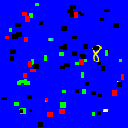

In [599]:
batch = pipeline.next_batch(32, shuffle=True)
batch.images[0]

In [615]:
batch.masks